In [236]:
library(tidyverse)
library(pbapply)
library(parallel)
library(assertthat)
library(sf)
library(pROC)
library(patchwork)
library(vroom)
library(yardstick)
library(rmapshaper)
library(here)
#source('R/utils.R')

In [237]:
loadRData <- function(fileName){
#loads an RData file, and returns it
    load(fileName)
    get(ls()[ls() != "fileName"])
}

In [238]:
ll_dfs <- loadRData('ll_dfs_rnn_5.RData')

In [239]:
# To evaluate predictive performance, remove years with no surveys
q_df <- ll_dfs %>%
  bind_rows %>%
  filter(!is.na(y), group == 'validation')

# compute prob of zero and prob of nonzero
q_df <- q_df %>%
  mutate(pr_zero = (1 - psi) + psi * (1 - p)^50, 
         estimate = 1 - pr_zero, 
         truth = factor(ifelse(y > 0, 'detected', 'not detected')))

roc_df_validation <- q_df %>%
  filter(group == 'validation') %>%
  group_by(route_id) %>%
  roc_curve(truth, estimate) %>%
  ungroup

auc_df_validation <- q_df %>%
  filter(group == 'validation') %>%
  group_by(route_id) %>%
  roc_auc(truth, estimate)


In [240]:
#head(q_df)

In [241]:
print(head(roc_df_validation))

# A tibble: 6 x 4
  route_id .threshold specificity sensitivity
  <chr>         <dbl>       <dbl>       <dbl>
1 02_041   -Inf          0                  1
2 02_041      1.23e-8    0                  1
3 02_041      1.62e-8    0.000274           1
4 02_041      1.65e-8    0.000548           1
5 02_041      2.45e-8    0.000822           1
6 02_041      3.46e-8    0.00110            1


In [242]:
print(head(auc_df_validation))

# A tibble: 6 x 4
  route_id .metric .estimator .estimate
  <chr>    <chr>   <chr>          <dbl>
1 02_041   roc_auc binary         0.865
2 02_070   roc_auc binary         0.955
3 02_141   roc_auc binary         0.900
4 02_142   roc_auc binary         0.967
5 02_217   roc_auc binary         0.947
6 03_001   roc_auc binary         0.866


Joining, by = "route_id"



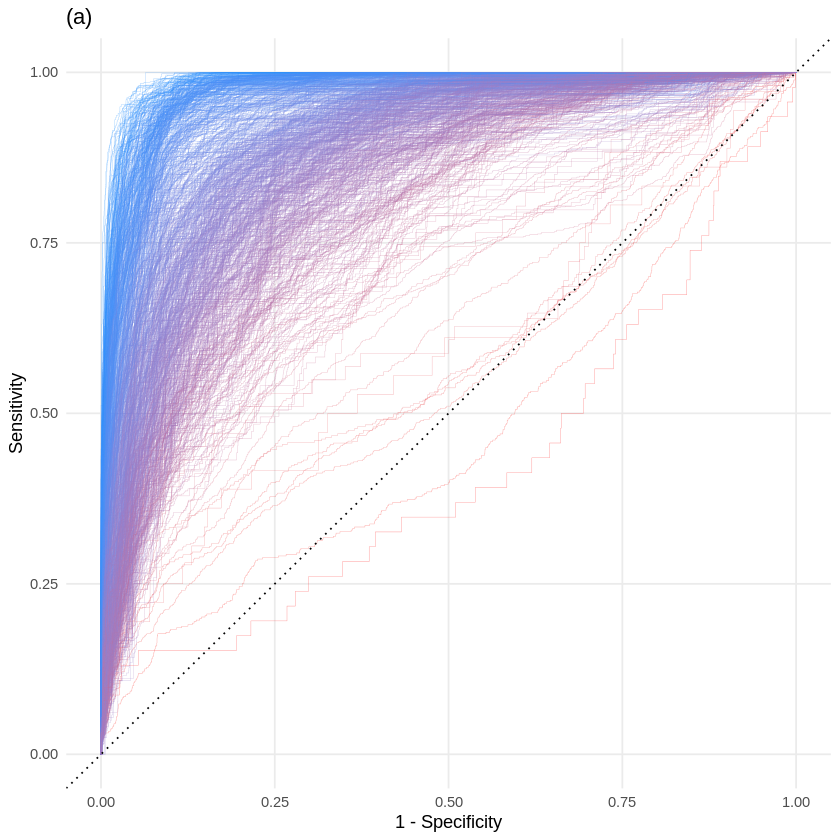

In [243]:
roc_plot <- roc_df_validation %>%
  left_join(auc_df_validation) %>%
  ggplot(aes(x = 1 - specificity, y = sensitivity, group = route_id, 
             color = .estimate)) +
  geom_path(alpha = .5, size = .1) +
  geom_abline(lty = 3) +
  theme_minimal() + 
  theme(panel.grid.minor = element_blank(), legend.position = 'none') + 
  xlab("1 - Specificity") + 
  ylab("Sensitivity") + 
  ggtitle('(a)') +
  scale_color_gradient(low = 'red', high = 'dodgerblue', 'AUC')
roc_plot

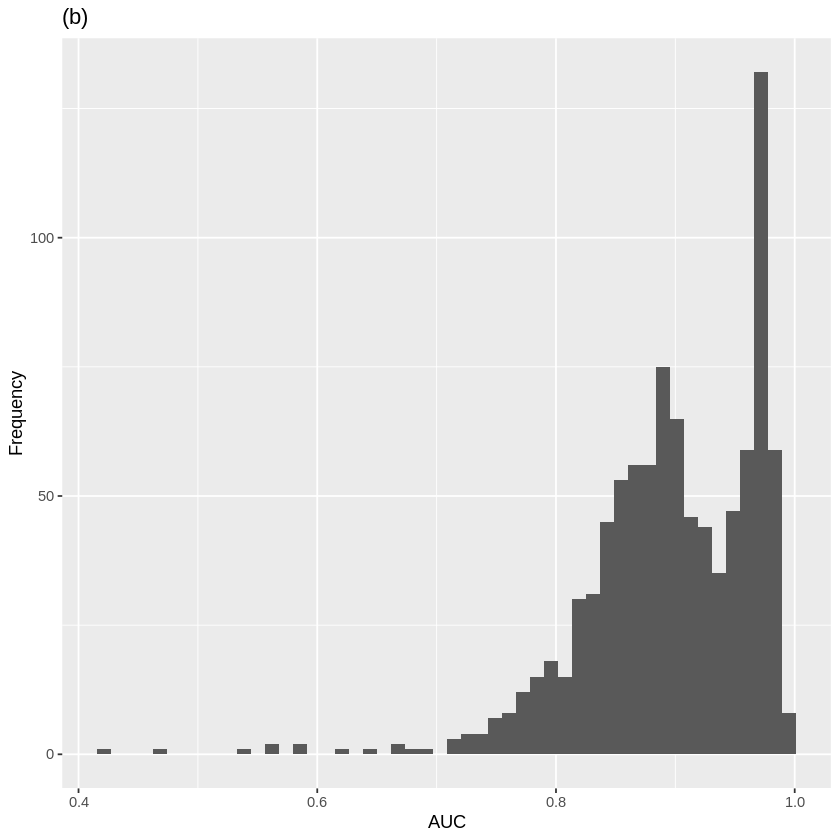

In [244]:
auc_plot <- auc_df_validation %>%
  ggplot(aes(.estimate)) + 
  geom_histogram(bins=50) + 
  xlab('AUC') + 
  ylab("Frequency") + 
  ggtitle('(b)')
auc_plot

In [245]:
packageVersion("tibble")
packageVersion("sf")
packageVersion("vctrs")

#https://community.rstudio.com/t/tibble-must-be-vectors/72888

[1] ‘3.0.4’

[1] ‘0.9.6’

[1] ‘0.3.5’

In [246]:
routes <- st_read('data/cleaned/routes.shp') %>%
  left_join(auc_df_validation) %>%
  st_transform(3174)

Reading layer `routes' from data source `/pfs/data5/home/fr/fr_fr/fr_ty14/neuralecology/data/cleaned/routes.shp' using driver `ESRI Shapefile'
Simple feature collection with 4641 features and 17 fields
geometry type:  POINT
dimension:      XY
bbox:           xmin: -176.6358 ymin: 24.5977 xmax: -53.4743 ymax: 69.18743
CRS:            4326


Joining, by = "route_id"



In [247]:
ecoregions <- st_read('data/NA_CEC_Eco_Level3/NA_CEC_Eco_Level3.shp') %>%
  st_transform(st_crs(routes)) %>%
  ms_simplify

Reading layer `NA_CEC_Eco_Level3' from data source `/pfs/data5/home/fr/fr_fr/fr_ty14/neuralecology/data/NA_CEC_Eco_Level3/NA_CEC_Eco_Level3.shp' using driver `ESRI Shapefile'
Simple feature collection with 2548 features and 11 fields
geometry type:  POLYGON
dimension:      XY
bbox:           xmin: -4334052 ymin: -3313739 xmax: 3324076 ymax: 4267265
proj4string:    +proj=laea +lat_0=45 +lon_0=-100 +x_0=0 +y_0=0 +a=6370997 +b=6370997 +units=m +no_defs 


In [248]:
l2_regions <- ecoregions %>%
  group_by(NA_L2KEY) %>%
  summarize

`summarise()` ungrouping output (override with `.groups` argument)



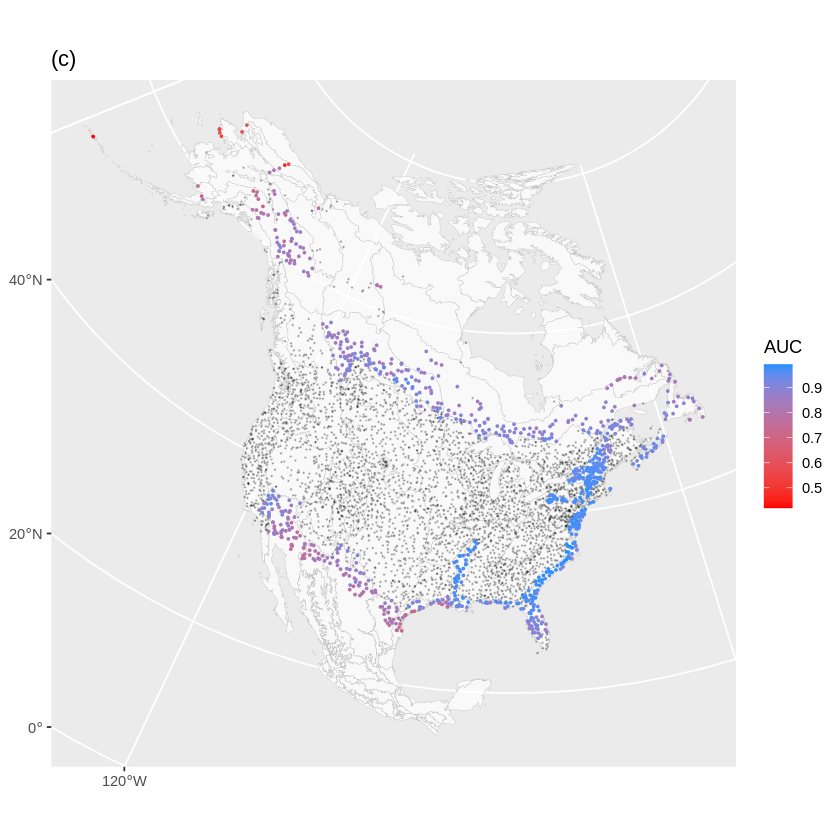

In [249]:
auc_map <- routes %>%
  ggplot() +
  geom_sf(data = l2_regions, fill = 'white', size = .1, alpha = .7, 
          color ='grey') +
  geom_sf(alpha = .2, size = .1) + 
  geom_sf(aes(color = .estimate), 
          data = filter(routes, !is.na(.estimate)), size = .4) +
  scale_color_gradient(low = 'red', high = 'dodgerblue', 'AUC') + 
  ggtitle('(c)')
auc_map

In [250]:
write_csv(roc_df_validation, 'out_round_5/auc/roc_df-validation_rnn.csv')
write_csv(auc_df_validation, 'out_round_5/auc/auc_df-validation_rnn.csv')

In [251]:
# Compute and save validation set interval coverage stats -----------------------

coverage_df <- q_df %>%
  filter(group == 'validation') %>%
  mutate(y_less_than_pred = y < conditional_lo,
         y_more_than_pred = y > conditional_hi,
         y_in_interval = conditional_lo <= y & y <= conditional_hi) %>%
  group_by(route_id) %>%
  summarize(coverage = mean(y_in_interval), 
            y_below = mean(y_less_than_pred), 
            y_above = mean(y_more_than_pred))
write_csv(coverage_df, 'out_round_5/auc/coverage_df-validation_rnn.csv')

`summarise()` ungrouping output (override with `.groups` argument)

